# ENTRENAMIENTO DE MODELOS
------------

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

df = pd.read_csv('final_dataset.csv')

# Eliminamos columnas no útiles para el modelo o que no tienen relacion con la label objetivo.
X = df.drop(columns=['account_type', 'id', 'created_at', 'screen_name'])
y = df['account_type']

# División del dataset en tres subconjuntos: entrenamiento (60%), validación (20%) y test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Tamaño de los conjuntos - Entrenamiento: {X_train.shape}, Validación: {X_val.shape}, Test: {X_test.shape}")

Tamaño de los conjuntos - Entrenamiento: (22462, 19), Validación: (7488, 19), Test: (7488, 19)


### Pipelines

Se configuran tres pipelines diferentes: uno para el modelo de K-Nearest Neighbors (KNN), uno para el modelo de Support Vector Machine (SVM) y otro para el modelo de Random Forest. Cada pipeline combina el escalado de los datos, la reducción de dimensionalidad con PCA y el ajuste del modelo.


In [2]:
# PCA para reducción de dimensionalidad
pca = PCA(n_components=0.9)  # Mantener el 90% de la varianza

# Se crean pipelines para cada modelo, lo que permite escalar los datos y ajustar el modelo en un solo paso.

# Pipeline para KNN
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()), # Escalado de los datos
    ('pca', pca), # Reducción de dimensionalidad
    ('knn', KNeighborsClassifier())  # Modelo KNN
])

# Pipeline para SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),  # Escalado de los datos
    ('pca', pca), # Reducción de dimensionalidad
    ('svm', SVC())  # Modelo SVM
])

# Pipeline para Random Forest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),  # Escalado de los datos
    ('pca', pca), # Reducción de dimensionalidad
    ('rf', RandomForestClassifier(random_state=42))  # Modelo Random Forest
])

### Hiperparametros

Aquí, GridSearchCV de sklearn.model_selection se utiliza para explorar de forma sistemática múltiples combinaciones de hiperparámetros. GridSearchCV probará todas las combinaciones especificadas y seleccionará la que ofrezca el mejor rendimiento en términos de una métrica de evaluación específica (precisión en este caso).
Cada modelo tiene configuraciones de hiperparámetros específicas que determinan su comportamiento.


In [3]:
# Se definen diferentes combinaciones de hiperparámetros para cada modelo, que serán probadas por el GridSearchCV.

# Hiperparámetros para KNN
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],  # Número de vecinos a probar
    'knn__weights': ['uniform', 'distance'],  # Pesos
    'knn__metric': ['euclidean', 'manhattan'],  # Métricas de distancia
    'pca__n_components': [0.9, 0.95, 0.99]  # Número de componentes principales
}

# Hiperparámetros para SVM
param_grid_svm = {
    'svm__C': [0.1, 1, 10, 100],  # Parámetro de regularización
    'svm__kernel': ['linear', 'rbf'],  # Tipos de kernel
    'svm__gamma': ['scale', 'auto'],  # Gamma
    'pca__n_components': [0.9, 0.95, 0.99]  # Número de componentes principales
}

# Hiperparámetros para Random Forest
param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],  # Número de árboles
    'rf__max_depth': [None, 20, 30, 40],  # Profundidad máxima
    'rf__min_samples_split': [2, 5, 10],  # Mínimo de muestras para hacer una división
    'pca__n_components': [0.9, 0.95, 0.99]  # Número de componentes principales
}

### GridSearchCV

La técnica de Grid Search permite probar todas las combinaciones de hiperparámetros especificadas y elegir la que mejor rendimiento proporcione. Al combinar Grid Search con cross-validation (validación cruzada), se garantiza que el modelo se evalúe de manera rigurosa en múltiples subconjuntos de los datos, obteniendo así una estimación confiable de su rendimiento. Esto ayuda a evitar problemas de sobreajuste y garantiza que el modelo generalice bien a datos nuevos.


In [4]:
# Se configura el ajuste de hiperparámetros usando GridSearchCV para cada modelo, lo que realiza una búsqueda exhaustiva sobre los hiperparámetros proporcionados.

# KNN con GridSearchCV
grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=3, n_jobs=-1, scoring='accuracy')
grid_knn.fit(X_train, y_train)

# SVM con GridSearchCV
grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=3, n_jobs=-1, scoring='accuracy')
grid_svm.fit(X_train, y_train)

# Random Forest con GridSearchCV
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, n_jobs=-1, scoring='accuracy')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.9)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [0.9, 0.95, 0.99],
                         'rf__max_depth': [None, 20, 30, 40],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [50, 100, 200]},
             scoring='accuracy')

### Evaluación en el conjunto de validacion

Se evalúa el rendimiento de cada modelo entrenado en el conjunto de validación y se presentan  los mejores hiperparámetros seleccionados durante el proceso de búsqueda con GridSearchCV. Se emplea para obtener una visión clara de la configuración óptima y la capacidad predictiva de cada modelo.

In [5]:
models = {
    'KNN': grid_knn,
    'SVM': grid_svm,
    'Random Forest': grid_rf,
}

for name, model in models.items():
    y_val_pred = model.predict(X_val)
    print(f"--- {name} ---")
    print(f"Mejores parámetros: {model.best_params_}")
    print(f"Precisión en validación: {accuracy_score(y_val, y_val_pred):.4f}")

--- KNN ---
Mejores parámetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance', 'pca__n_components': 0.9}
Precisión en validación: 0.8174
--- SVM ---
Mejores parámetros: {'pca__n_components': 0.95, 'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Precisión en validación: 0.7835
--- Random Forest ---
Mejores parámetros: {'pca__n_components': 0.99, 'rf__max_depth': 20, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Precisión en validación: 0.8379


La precisión en la validación alcanzada por el modelo KNN fue del 81.74%. Este resultado indica que, aunque se trata de un modelo simple y fácilmente interpretable, su desempeño en este conjunto de datos es sólido. El mejor rendimiento se obtuvo utilizando la métrica Manhattan, con 9 vecinos, ponderación por distancia y una reducción de dimensionalidad mediante PCA conservando el 90% de la varianza.

El modelo Random Forest alcanzó una precisión de 83.79% en la validación, lo que lo posiciona como el más efectivo entre los tres evaluados. Su buen desempeño se atribuye a su naturaleza de ensamble, que permite combinar múltiples árboles de decisión para mejorar la capacidad predictiva. Los mejores resultados se lograron con una profundidad máxima de 20, un mínimo de 10 muestras por división, 200 estimadores y un PCA conservando el 99% de la varianza.

Finalmente, el modelo SVM obtuvo una precisión del 78.34% en la validación. Aunque su rendimiento fue inferior al de los otros modelos, sigue mostrando una buena capacidad de clasificación. Los mejores resultados se alcanzaron utilizando un kernel RBF, con C = 100, γ = auto y una reducción de dimensionalidad mediante PCA con el 95% de la varianza retenida

### Evaluación en el conjunto de test

Se evalúa el rendimiento de los modelos entrenados en el conjunto de prueba (X_test y y_test). La evaluación en el conjunto de prueba proporciona una medida final de la precisión y capacidad de generalización de los modelos, y muestra la capacidad de estos para predecir correctamente en datos nuevos. En este caso, se calculan y visualizan la precisión, la matriz de confusión y el reporte de clasificación para cada modelo.

--- KNN ---
Precisión en test: 0.8168
Matriz de confusión:


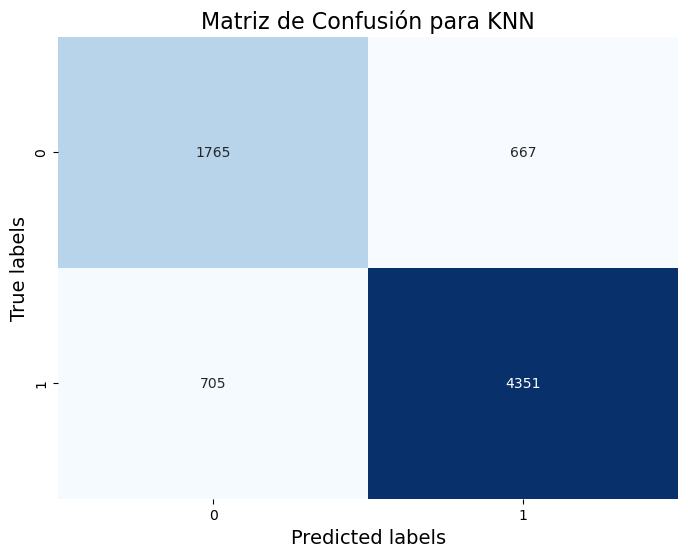

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      2432
           1       0.87      0.86      0.86      5056

    accuracy                           0.82      7488
   macro avg       0.79      0.79      0.79      7488
weighted avg       0.82      0.82      0.82      7488

--- SVM ---
Precisión en test: 0.7878
Matriz de confusión:


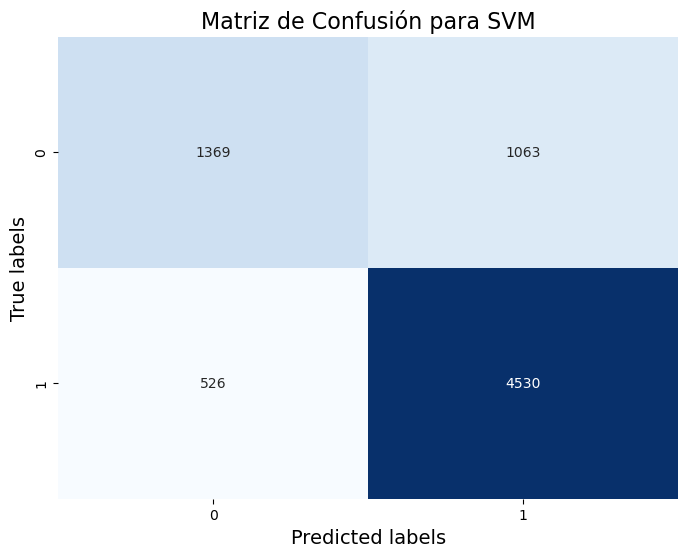

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.72      0.56      0.63      2432
           1       0.81      0.90      0.85      5056

    accuracy                           0.79      7488
   macro avg       0.77      0.73      0.74      7488
weighted avg       0.78      0.79      0.78      7488

--- Random Forest ---
Precisión en test: 0.8424
Matriz de confusión:


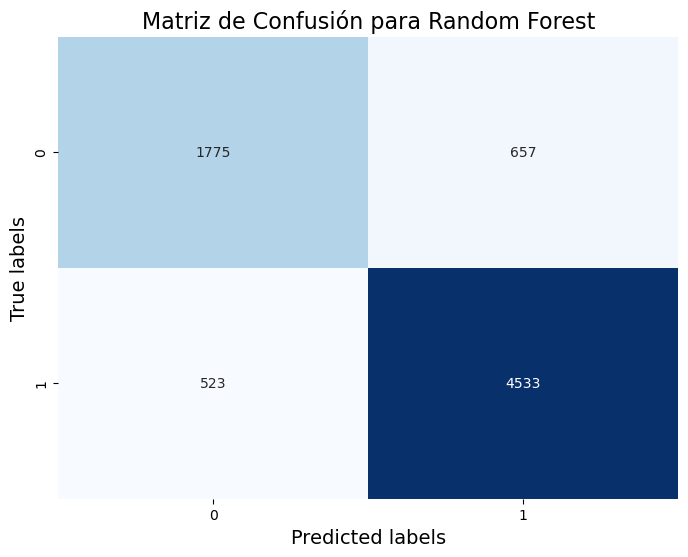

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      2432
           1       0.87      0.90      0.88      5056

    accuracy                           0.84      7488
   macro avg       0.82      0.81      0.82      7488
weighted avg       0.84      0.84      0.84      7488



In [6]:
for name, model in models.items():
    y_test_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print(f"Precisión en test: {accuracy_score(y_test, y_test_pred):.4f}")
    print("Matriz de confusión:")
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión para {name}', fontsize=16)
    plt.xlabel('Predicted labels', fontsize=14)
    plt.ylabel('True labels', fontsize=14)
    plt.show()
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_test_pred))

KNN AUC-ROC (val): 0.8822
SVM AUC-ROC (val): 0.8355
Random Forest AUC-ROC (val): 0.9061


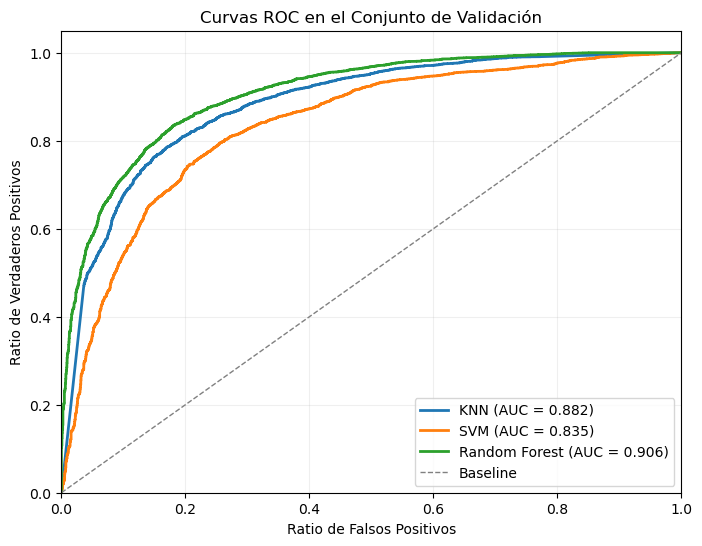

In [ ]:
for name, model in models.items():
    # For probability-based AUC (preferred)
    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val)[:, 1]
    else:
        # fallback for SVM with decision_function
        y_val_proba = model.decision_function(X_val)
    auc = roc_auc_score(y_val, y_val_proba)
    print(f"{name} AUC-ROC (val): {auc:.4f}")
    
plt.figure(figsize=(8, 6))
for name, model in models.items():
    # Get scores (probabilities preferred)
    if hasattr(model, "predict_proba"):
        y_val_score = model.predict_proba(X_val)[:, 1]
    else:
        y_val_score = model.decision_function(X_val)

    auc_val = roc_auc_score(y_val, y_val_score)
    fpr, tpr, _ = roc_curve(y_val, y_val_score)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_val:.3f})")

# Baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de Falsos Positivos')
plt.ylabel('Ratio de Verdaderos Positivos')
plt.title('Curvas ROC en el Conjunto de Validación')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.show()

En el conjunto de prueba, el modelo Random Forest obtuvo el mejor desempeño con una precisión del 84.24%, destacándose por su equilibrio entre precision y recall en ambas clases (f1-score promedio = 0.84). El modelo KNN logró una precisión del 81.68%, mostrando un rendimiento sólido y balanceado, aunque con menor sensibilidad hacia la clase 0. En contraste, el SVM alcanzó una precisión del 78.77%, presentando una alta capacidad para identificar la clase 1 (recall = 0.90) pero un desempeño notablemente inferior en la clase 0 (recall = 0.56). En conjunto, los resultados confirman que Random Forest ofrece la mejor capacidad de generalización y estabilidad entre los modelos evaluados, seguido de KNN, mientras que SVM requiere un ajuste adicional para mejorar su balance entre clases.

### Comparación y Conclusión:

Los resultados obtenidos en el conjunto de prueba muestran diferencias claras en el desempeño de los tres modelos evaluados (KNN, SVM y Random Forest), tanto en términos de precisión global como en las métricas por clase.

El modelo KNN alcanzó una precisión general del 81.68%, con valores equilibrados de precision y recall entre ambas clases. En particular, el modelo muestra un buen desempeño en la detección de cuentas de tipo 1 (recall = 0.86, f1-score = 0.86), aunque su rendimiento es ligeramente inferior para las cuentas de tipo 0 (recall = 0.73, f1-score = 0.72). Esto sugiere que el modelo tiende a clasificar correctamente la mayoría de los casos positivos, pero con una leve pérdida de sensibilidad hacia la clase minoritaria. En conjunto, su equilibrio entre simplicidad, interpretabilidad y desempeño lo posiciona como una opción competitiva dentro de los modelos supervisados más básicos.

El modelo SVM obtuvo una precisión en prueba del 78.77%, siendo el de menor rendimiento entre los tres. El análisis del reporte de clasificación muestra un desbalance en la capacidad de generalización entre clases: mientras que para la clase 1 logra un recall elevado (0.90), para la clase 0 el valor desciende significativamente (0.56). Esto indica una tendencia del modelo a sobreclasificar hacia la clase mayoritaria, sacrificando sensibilidad en la minoritaria. A pesar de ello, el f1-score de 0.85 en la clase 1 refleja una buena capacidad de discriminación en los casos positivos, aunque con menor precisión global.

Por su parte, el modelo Random Forest obtuvo el mejor desempeño global, con una precisión del 84.24%. Además de lograr el mayor accuracy, presenta valores consistentes en todas las métricas y clases (precision, recall y f1-score cercanos entre sí). El f1-score de 0.88 para la clase 1 y de 0.75 para la clase 0 reflejan una mayor estabilidad y robustez en la clasificación, producto de la naturaleza de ensamble del algoritmo, que permite reducir el sobreajuste y capturar relaciones no lineales entre las variables.

En síntesis, el Random Forest demuestra ser el modelo más equilibrado y eficaz para este problema de clasificación, seguido de KNN, que ofrece un rendimiento competitivo con menor complejidad computacional. El SVM, aunque útil para identificar la clase mayoritaria, presenta limitaciones al generalizar correctamente los casos de la clase minoritaria, lo que sugiere la necesidad de un ajuste adicional en sus hiperparámetros o en el balance del conjunto de entrenamiento.


### Exportación del Modelo

Una vez que hemos identificado que el Random Forest es el modelo con mejor rendimiento, procedemos a exportarlo para su reutilización en un script de predicción independiente.


In [ ]:
# Importar joblib para exportar el modelo
import joblib
import os

# Crear directorio para guardar el modelo si no existe
model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Exportar el mejor modelo (Random Forest)
best_model = grid_rf.best_estimator_
joblib.dump(best_model, os.path.join(model_dir, 'random_forest_model.pkl'))

print("Modelo Random Forest exportado exitosamente!")
print(f"Ubicación: {os.path.join(model_dir, 'random_forest_model.pkl')}")

# También exportar información sobre las columnas para el script de predicción
feature_columns = list(X.columns)
joblib.dump(feature_columns, os.path.join(model_dir, 'feature_columns.pkl'))

print(f"Columnas de características exportadas: {len(feature_columns)} columnas")
print("Columnas:", feature_columns)


Modelo Random Forest exportado exitosamente!
Ubicación: model\random_forest_model.pkl
Columnas de características exportadas: 19 columnas
Columnas: ['description', 'favourites_count', 'followers_count', 'friends_count', 'location', 'statuses_count', 'verified', 'average_tweets_per_day', 'account_age_days', 'follow_ratio', 'popularity_index', 'engagement_ratio', 'activity_index', 'profile_completeness', 'followers_per_day', 'suspicion_index', 'reciprocity_ratio', 'influence_index', 'growth_index']
